In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm


In [2]:
class Strategy:
    def __init__(self, values: np.ndarray) -> None:
        assert np.all(values.shape == (2, 2, 2)), "values must be a 2x2x2 array"
        # self.values = np.flip(values.transpose((2, 0, 1)), axis=(1, 2))
        self.values = values.transpose((2, 0, 1))

    def __call__(self, p: float | np.ndarray, q: float | np.ndarray) -> np.ndarray:
        return (
            np.stack([p, 1 - p], axis=-1)[None, ..., None, :]
            @ (
                self.values[
                    :,
                    *([None] * len(p.shape) if isinstance(p, np.ndarray) else []),
                    ...,
                ]
                @ np.stack([q, 1 - q], axis=-1)[None, ..., None]
            )
        ).squeeze()

    def partial(self, p: float | np.ndarray, q: float | np.ndarray) -> np.ndarray:
        return np.array(
            [
                (
                    self.values[
                        0,
                        *([None] * len(p.shape) if isinstance(p, np.ndarray) else []),
                        ...,
                    ]
                    @ np.stack([q, 1 - q], axis=-1)[None, ..., None]
                ).squeeze()
                @ np.array([1, -1]),
                (
                    self.values[
                        1,
                        *([None] * len(p.shape) if isinstance(p, np.ndarray) else []),
                        ...,
                    ]
                    @ np.array([1, -1])
                    @ np.stack([p, 1 - p], axis=-1)[None, ..., None]
                ).squeeze(),
            ]
        )

    def value_p(self, p: float, q: float) -> np.ndarray:
        return self(p, q)[0]

    def value_q(self, p: float, q: float) -> np.ndarray:
        return self(p, q)[1]

    def partial_p(self, p: float, q: float) -> np.ndarray:
        return self.partial(p, q)[0]

    def partial_q(self, p: float, q: float) -> np.ndarray:
        return self.partial(p, q)[1]


In [3]:
# 6-31
NAME = "6-31"
S = Strategy(
    np.array(
        [
            [[2, 15], [4, 20]],
            [[6, 6], [10, 8]],
        ]
    )
)

# 6-32
NAME = "6-32"
S = Strategy(
    np.array(
        [
            [[3, 5], [4, 3]],
            [[2, 1], [1, 6]],
        ]
    )
)

# 6-33
NAME = "6-33"
S = Strategy(
    np.array(
        [
            [[1, 1], [4, 2]],
            [[3, 3], [2, 2]],
        ]
    )
)

# 6-37
NAME = "6-37"
S = Strategy(
    np.array(
        [
            [[8, 4], [5, 5]],
            [[3, 3], [4, 8]],
        ]
    )
)

# 6-38
NAME = "6-38"
S = Strategy(
    np.array(
        [
            [[0, 0], [-1, 1]],
            [[-1, 1], [2, -2]],
        ]
    )
)


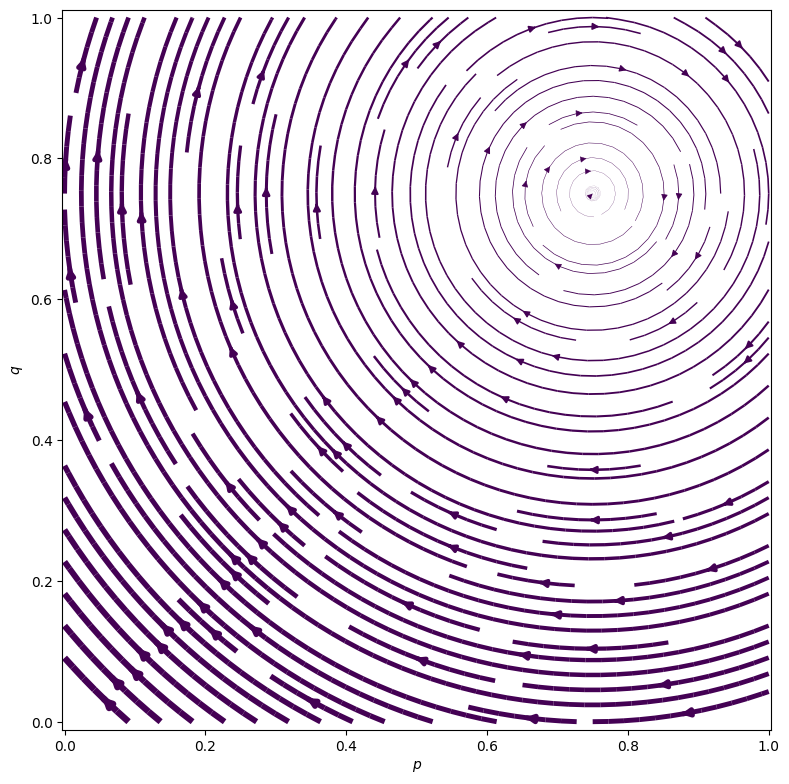

In [4]:
pp, qq = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
dd = S.partial(pp, qq)
vv = S(pp, qq)
lw = 5 * np.sqrt((dd**2).sum(axis=0)) / np.sqrt((dd**2).sum(axis=0)).max()
lc = vv.sum(axis=0)

fig = plt.figure(figsize=(8, 8))
plt.streamplot(pp, qq, dd[0], dd[1], color=lc, density=1.5, linewidth=lw)
plt.xlabel(r"$p$")
plt.ylabel(r"$q$")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f"{NAME}.png")


In [5]:
xx, yy = pp.copy(), qq.copy()
last_xx, last_yy = xx.copy(), yy.copy()
last_vx, last_vy = S.partial(xx, yy)


if not os.path.exists("frames"):
    os.makedirs("frames")
os.system("rm -rf frames/*")


episode = 1000
plot_full = 50
dt = 0.1
frame_idx = 0
stop_thresh = 5
no_change_since = 0
to_stop = False


def plot_func(i: int) -> bool:
    return i < plot_full or i - plot_full == int(np.sqrt(i - plot_full)) ** 2


for i in tqdm(range(episode)):
    if plot_func(i) or to_stop:
        fig = plt.figure(figsize=(8, 8))
        plt.streamplot(pp, qq, dd[0], dd[1], color=lc, density=1.5, linewidth=lw)
        try:
            K = gaussian_kde(np.stack([xx.flatten(), yy.flatten()]))
            zz = K(np.stack([pp.flatten(), qq.flatten()])).reshape(pp.shape)
            plt.contour(pp, qq, zz, levels=10, cmap="coolwarm")
        except:
            # This is due to the collapse of dimension
            pass
        plt.scatter(xx, yy, s=10, c="red", alpha=0.25)
        plt.xlabel(r"$p$")
        plt.ylabel(r"$q$")
        plt.axis("equal")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.savefig(f"frames/{frame_idx:04d}.png")
        plt.close()
        frame_idx += 1

    if to_stop:
        break
    vx, vy = S.partial(xx, yy)
    # Compensate for overshooting
    # as we are approximating ODE
    # with discrete time steps
    xx += vx * dt * 1.55 - last_vx * dt * 0.55
    yy += vy * dt * 1.55 - last_vy * dt * 0.55
    np.clip(xx, 0, 1, xx)
    np.clip(yy, 0, 1, yy)
    no_change_since = (
        no_change_since + 1
        if np.allclose(last_xx, xx) and np.allclose(last_yy, yy)
        else 0
    )
    last_xx, last_yy = xx.copy(), yy.copy()
    last_vx, last_vy = vx.copy(), vy.copy()
    to_stop = no_change_since > stop_thresh


100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


In [6]:
os.system(f"ffmpeg -y -r 12 -i frames/%04d.png -vcodec libx264 -pix_fmt yuv420p {NAME}.mp4")
os.system("rm -rf frames/*")


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.3.0-1ubuntu1~22.04)
  configuration: --prefix=/home/linuxbrew/.linuxbrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=gcc-11 --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libj

0